# Recreating SIFT Detector

I learned about the SIFT detection algorithm for images and how it can be used for object tracking. I'm going to try and reimplement it using OpenCV, scikit-image, and numpy. I'm going to be using it on a still this traffic footage that I got (for educational purposes). I plan to implement full object tracking using OpenCV.

In [2]:
import cv2
import numpy as np
from IPython import display as disp
from ipywidgets import IntSlider, FloatSlider, Button, Output, VBox
from matplotlib import pyplot as plt
import skimage as ski
from tqdm.notebook import tqdm

# Configuration
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

def display_sample_of_3d(image3d, labels, x=3, y=3, m=None):
    fig, axs = plt.subplots(x, y)
    c = x*y
    m = m or len(labels) // c
    for i in range(c):
        axs.flat[i].imshow(image3d[m*i,:,:])
        axs.flat[i].set_title(labels[m*i])

video_file = '../../data/traffic-video.mp4'

disp.Video(video_file)

## SIFT detector

Let's first get a single still from this video and see what we can produce from it. We'll convert it to grayscale to make things a bit easier for us to write the detector.

(720, 1280) float64


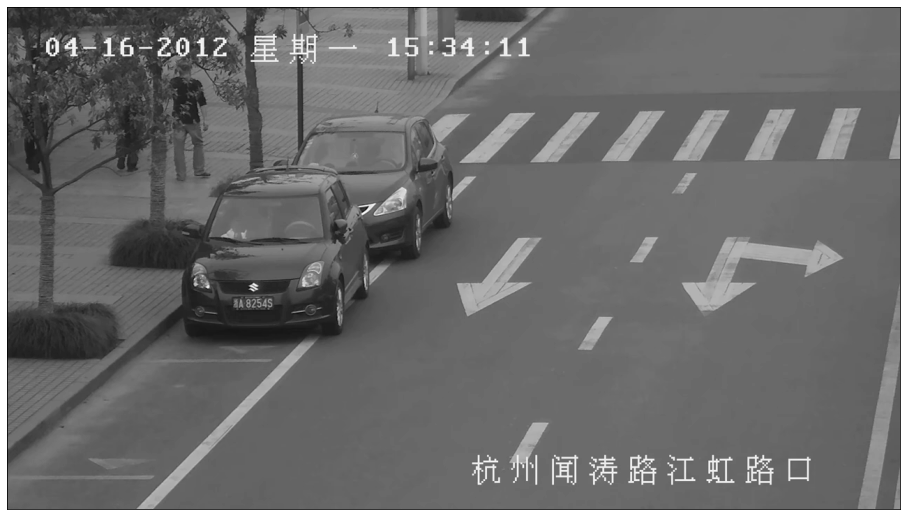

In [3]:
cap = cv2.VideoCapture(video_file)
_,color_frame = cap.read()
cap.release()
gray_frame = cv2.cvtColor(color_frame, cv2.COLOR_BGR2GRAY)
float_frame = gray_frame.astype(np.float64)

def display_output():
    print(float_frame.shape, float_frame.dtype)
    plt.imshow(float_frame)
    plt.show()

##
# downscale_slider = FloatSlider(value=.9, min=(0.001 + 1/min(full_frame.shape)), max=1.)
# button = Button(description="Downscale")
# output = Output()
# app = VBox([ downscale_slider, button, output ])
# def on_click(e):
#     global gray_frame, float_frame
#     output.clear_output()
#     float_frame = ski.transform.rescale(gray_frame, downscale_slider.value)
#     with output:
#         display_output()
# button.on_click(on_click)
# app

display_output()

The first thing we need to do is create a stack of gaussians with different sigma ($\sigma$) values. We'll create a logarithmic range of sigmas according to the formula:

$$
\sigma_k = \sigma_0 s^k
$$

We'll set $\sigma_0$ and $s$ depending on what works best

In [4]:
sigma_0 = 10
sigma_f = 120
count = 200

range_stop = np.log10(sigma_f/sigma_0)
sigmas = sigma_0 * np.logspace(0, range_stop, num=count)
sigmas

array([ 10.  ,  10.13,  10.25,  10.38,  10.51,  10.64,  10.78,  10.91,
        11.05,  11.19,  11.33,  11.47,  11.62,  11.76,  11.91,  12.06,
        12.21,  12.36,  12.52,  12.68,  12.84,  13.  ,  13.16,  13.33,
        13.49,  13.66,  13.84,  14.01,  14.19,  14.36,  14.54,  14.73,
        14.91,  15.1 ,  15.29,  15.48,  15.68,  15.87,  16.07,  16.27,
        16.48,  16.69,  16.9 ,  17.11,  17.32,  17.54,  17.76,  17.98,
        18.21,  18.44,  18.67,  18.9 ,  19.14,  19.38,  19.63,  19.87,
        20.12,  20.38,  20.63,  20.89,  21.15,  21.42,  21.69,  21.96,
        22.24,  22.52,  22.8 ,  23.09,  23.38,  23.67,  23.97,  24.27,
        24.57,  24.88,  25.19,  25.51,  25.83,  26.16,  26.48,  26.82,
        27.15,  27.5 ,  27.84,  28.19,  28.55,  28.9 ,  29.27,  29.63,
        30.01,  30.38,  30.77,  31.15,  31.54,  31.94,  32.34,  32.75,
        33.16,  33.58,  34.  ,  34.43,  34.86,  35.3 ,  35.74,  36.19,
        36.64,  37.1 ,  37.57,  38.04,  38.52,  39.  ,  39.49,  39.99,
      

Then, for each sigma, we'll do a gaussian filter on the image to create a stack of filtered images. This will simulate viewing the image at different resolutions/scales

Computing Gaussians:   0%|          | 0/200 [00:00<?, ?it/s]

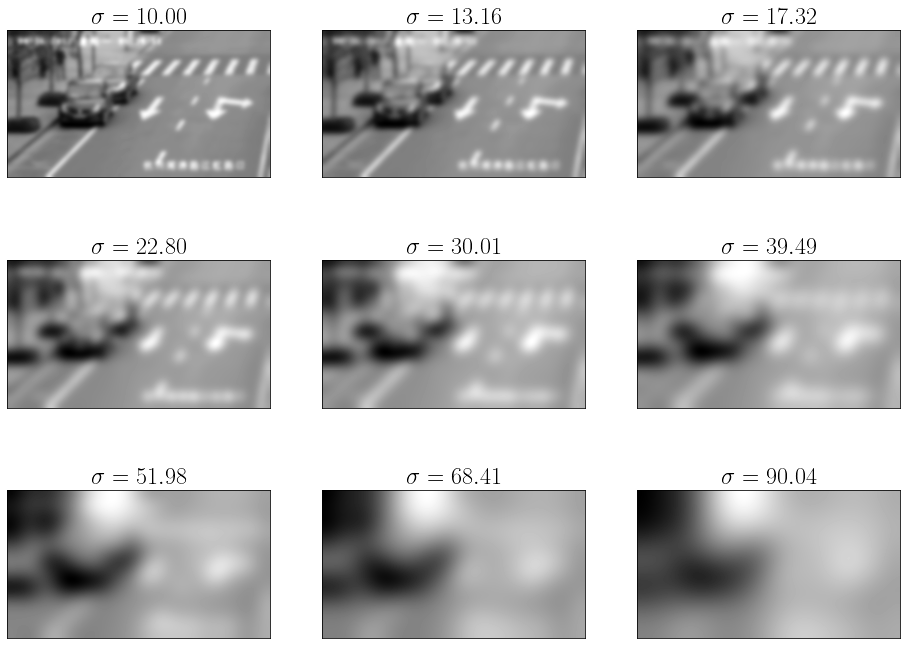

In [5]:
gaussians = np.array([ 
    cv2.GaussianBlur(float_frame, (0,0), sigma) 
    for sigma in tqdm(sigmas, desc='Computing Gaussians')
])
sigma_labels = [ f'$\sigma = {s:.2f}$' for s in sigmas ]

display_sample_of_3d(gaussians, sigma_labels)

Now we'll compute a Difference of Gaussians by subtracting adjacent gaussians in each row.

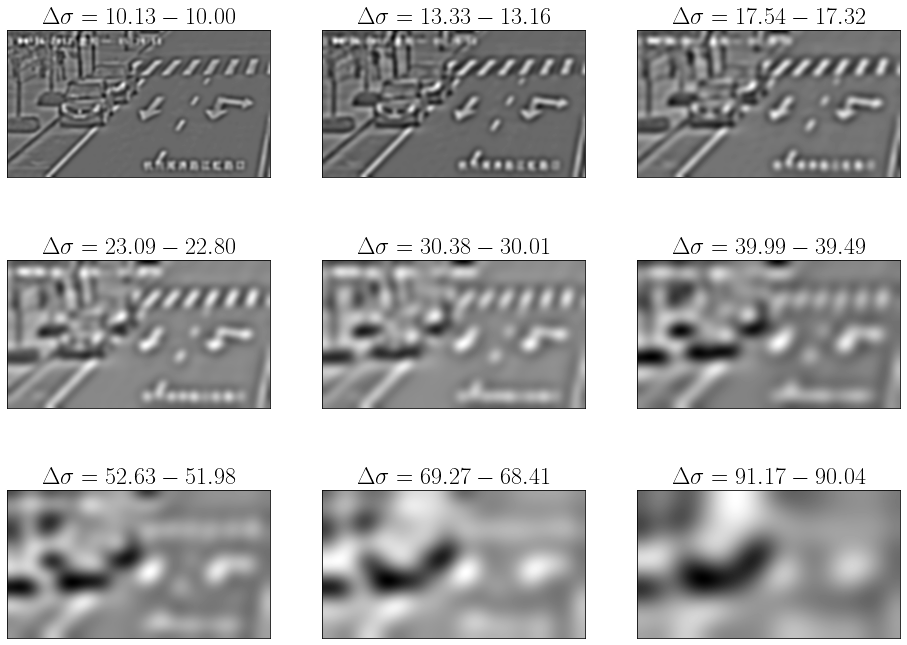

In [6]:
dogs = gaussians[:-1,:,:] - gaussians[1:,:,:]
delta_labels = [ f'$\Delta \sigma = {b:.2f} - {a:.2f}$' for a,b in zip(sigmas[:-1],sigmas[1:]) ]
display_sample_of_3d(dogs, delta_labels)

The (almost) final step is to find all local maximas in this 3D stack of images.

In [7]:
extrema = ski.feature.peak_local_max(dogs)
extrema

array([[   2,  272,  564],
       [   4,  273,  563],
       [   6,  273,  563],
       ...,
       [  44,  575, 1180],
       [  23,  623, 1189],
       [  33,  529, 1200]])

As can be seen we actually get 3 bits of information. We have the x/y coordinate of the feature in the image, but we also have the scale that the feature encompasses based on it's first coordinate. We can plot these as circles on the original image with the radius equal to the scale of the image

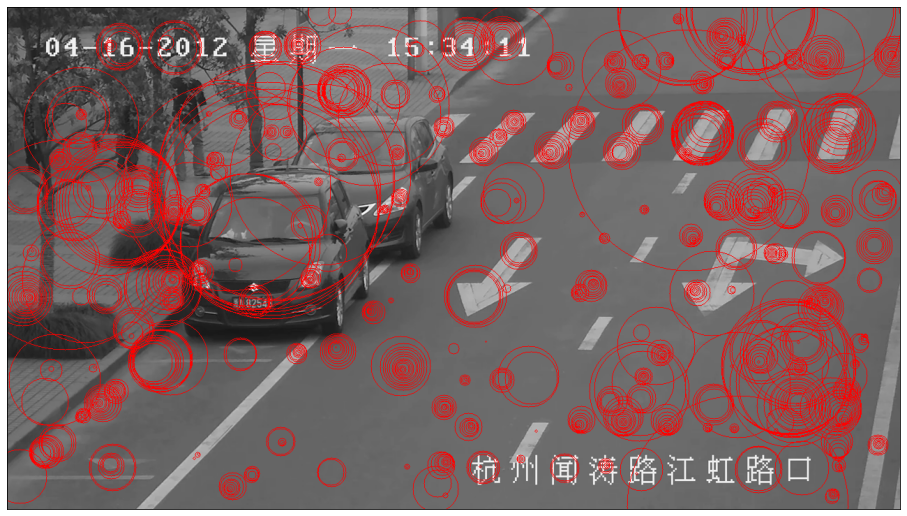

In [8]:
display_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
for s, y, x in extrema:
    display_frame = cv2.circle(display_frame, (x,y), s, (255, 0, 0))
plt.imshow(display_frame)
plt.show()

OpenCV has a SIFT detector of it's own. I'll compare what I have to what it outputs

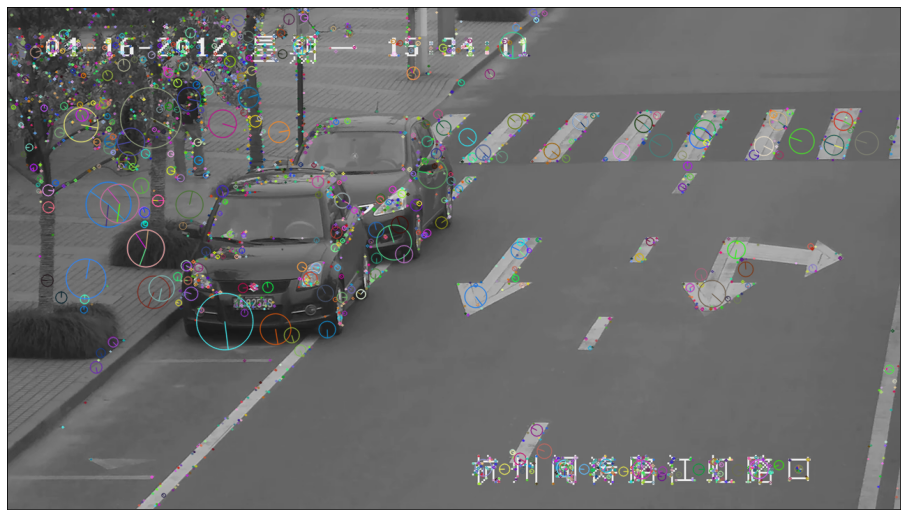

In [10]:
# Detect object using SIFT
sift = cv2.SIFT.create()
keypoints = sift.detect(gray_frame)
flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
frame_with_keypoints = cv2.drawKeypoints(gray_frame, keypoints, None, flags=flags)

# Show objects
plt.imshow(frame_with_keypoints)
plt.show()

Obviously OpenCV's version is much better and faster than my version. But I'm surprised mine worked! And it's pretty close too! I'll be making another notebook focused on tracking objects in the video. So, I'll use OpenCV's version in that.